- title: RDKit 入门：基于子结构修改分子
- slug: rdkit-modify-substructure
- date: 2023-02-06
- tags: RDKit, Python
- summary: 介绍使用 RDKit 修改分子的子结构，包括删除、替换、切割等操作以及对分子片段的处理。

## 删除子结构

In [1]:
from rdkit import Chem
from rdkit.Chem import AllChem

删除分子中的子结构需要用到 `DeleteSubstructs(m, patt)`，参数为需要修改的分子与分子片段，可选参数包括

- `onlyFrags=False`：是否当匹配片段为单独片段时才删除，默认为只要匹配一致即删除
- `useChirality=False`：是否匹配片段的手性

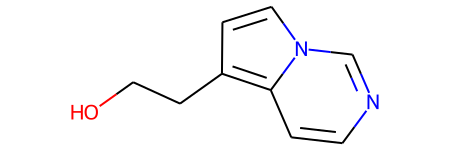

In [2]:
m = Chem.MolFromSmiles('OCCc1c2ccncn2cc1')
m

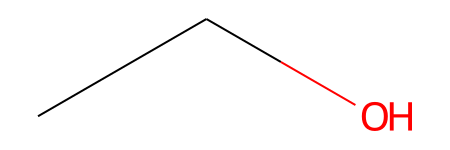

In [3]:
patt = Chem.MolFromSmarts('CCO')
patt_display = Chem.MolFromSmiles('CCO')
patt_display

子结构（分子片段）最好使用 SMART 形式导入，SMILES 的功能有限，很难准确表达分子片段，容易引起预料以外的错误。由于 RDKit 绘制 SMART 分子片段的效果不好，这里另外新建了一个 SMILES 形式的分子展示片段的结构。

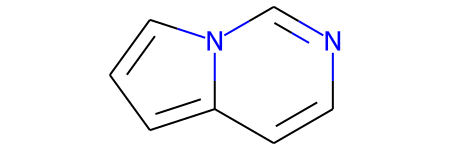

In [4]:
rm = AllChem.DeleteSubstructs(m, patt)
rm

含有两个碳的侧链被删去，分子仅剩下母核，需要注意在侧链与母核的连接处没有留下 `[*]` 标记的断点，这是删除与切割操作不同的地方。

{note begin}原分子未被修改，`DeleteSubstructs()` 返回一个新分子。{note end}

## 替换子结构

替换操作所使用的函数为 `ReplaceSubstructs(m, patt, ，replerepl)`，可选参数包括

- `replaceAll=False`：是否将一个分子中所有符合条件的片段都替换为替换片段，默认情况下，当分子中存在多个匹配项时，返回仅替换一个片段的多个分子（列表）。
- `replacementConnectionPoint=0`：手动指定替换片段与母核的成键位置。
- `useChirality=False`：是否匹配片段的手性

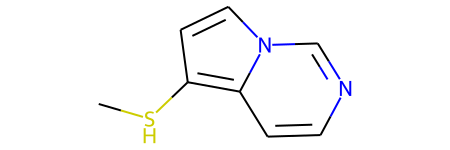

In [5]:
repl = Chem.MolFromSmiles('SC')
rms = AllChem.ReplaceSubstructs(m, patt, repl)
rms[0]

在替换时容易生成较为奇怪的分子，可以使用 `SanitizeMol()` 检查并修正分子结构。

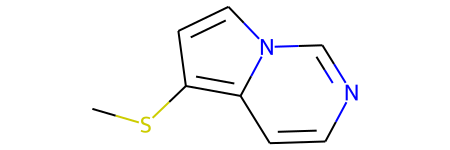

In [6]:
Chem.SanitizeMol(rms[0])
rms[0]

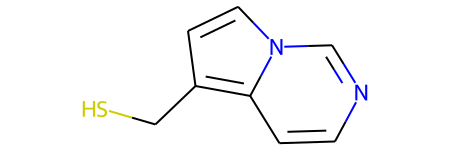

In [7]:
rms = AllChem.ReplaceSubstructs(m, patt, repl, replacementConnectionPoint=1)
rms[0]


{note begin}原分子同样未被修改，`ReplaceSubstructs()` 返回一个新分子的列表。{note end}

## 切割子结构

### 切除侧链

从分子中切除侧链，剩下分子母核，需要知道母核的 SMILES 序列，即在知道分子剩余部分 SMILES 序列的情况下，使用 `replaceSidechains(m, core)` 函数。

{note begin}勿被函数名中的「侧链」与「母核」迷惑，这里说的「侧链」与「母核」只是指代不同的两个部分，称其为「甲」与「乙」亦可，与化学概念上的「侧链」「母核」不同。使用 `replaceSidechains()` 可以切除「甲」部分，当然也可以切除「乙」部分。{note end}

[1*]c1ccn2cnccc12


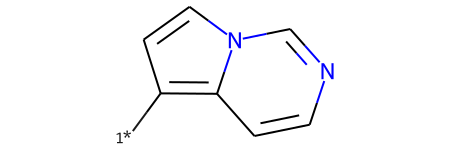

In [8]:
core = Chem.MolFromSmiles('c1cc2ccncn2c1')
m_cut = Chem.ReplaceSidechains(m, core)
print(Chem.MolToSmiles(m_cut))
m_cut

### 切除母核

从分子中切除母核，剩下分子侧链，需要知道母核的 SMILES 序列，即在知道分子切除部分 SMILES 序列的情况下，使用 `ReplaceCore(m, core)` 函数。

[1*]c1ccn2cnccc12


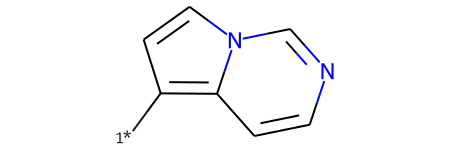

In [9]:
core = Chem.MolFromSmarts('CCO')
m_cut = Chem.ReplaceCore(m, core)
print(Chem.MolToSmiles(m_cut))
m_cut

虽然 `ReplaceSidechains()` 能实现与 `ReplaceCore()` 相同的操作，但 `ReplaceCore()` 具有额外更多的功能。`ReplaceCore()` 的可选参数包括

- `replaceDummies=True`：切除时是否包括子结构中的虚拟原子
- `labelByIndex=False`：是否根据母核原子的索引指定片段虚拟原子的编号
- `requireDummyMatch=False`：是否仅当侧链连接在虚拟原子上才执行操作

从以下分子中切除吡咯环将得到两条片段：

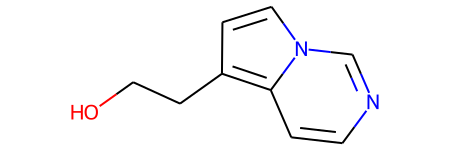

In [10]:
m

[1*]CCO.[2*]:ccnc:[3*]


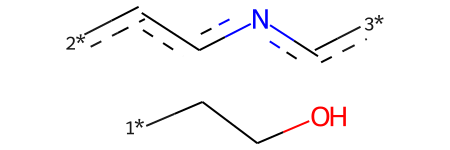

In [11]:
core = Chem.MolFromSmiles('c1cNcc1')
print(Chem.MolToSmiles(Chem.ReplaceCore(m, core)))
Chem.ReplaceCore(m, core)

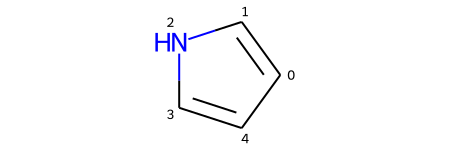

In [12]:
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import SVG

d = rdMolDraw2D.MolDraw2DSVG(450, 150)
do = d.drawOptions()
do.addAtomIndices = True
d.DrawMolecule(core)
d.FinishDrawing()
SVG(d.GetDrawingText())

*CCO.[1*]:ccnc:[2*]


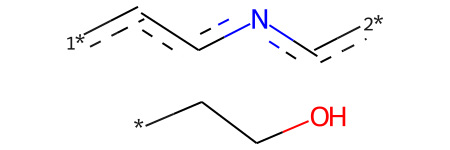

In [13]:
print(Chem.MolToSmiles(Chem.ReplaceCore(m, core, labelByIndex=True)))
Chem.ReplaceCore(m, core, labelByIndex=True)

指定参数 `labelByIndex=True`，片段中虚拟原子 `[*]` 编号就能与母核上的原子索引一致。


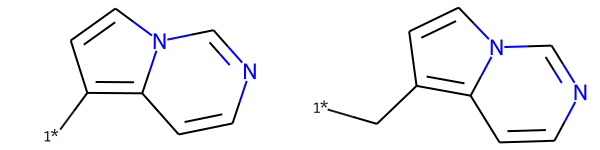

In [14]:
from rdkit.Chem import Draw

core = Chem.MolFromSmarts('[*]CO')
display = [Chem.ReplaceCore(m, core, replaceDummies=True), Chem.ReplaceCore(m, core, replaceDummies=False)]

Draw.MolsToGridImage([x for x in display], molsPerRow=2, subImgSize=(300,150))

左边为默认结果，右边为保留子结构中虚拟原子的结果，注意与前文中删除子结构的结果对比，避免具体操作中多删或漏删原子。


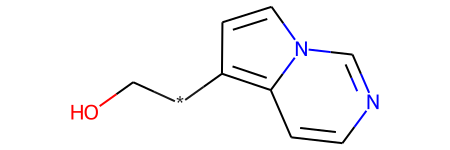

In [15]:
m1 = Chem.MolFromSmiles('OC*c1c2ccncn2cc1')
m1

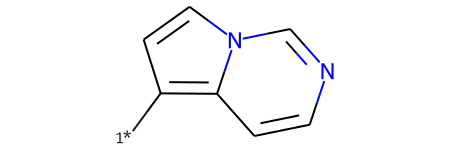

In [16]:
core = Chem.MolFromSmiles('[*]CO')
Chem.ReplaceCore(m1, core, requireDummyMatch=True)

指定 `requireDummyMatch=True` 后，原分子上相应位置必须也为虚拟原子（与搜索对象完全匹配）后才能进行切除。

{note begin}`replaceSidechains()` 与 `ReplaceCore()` 也不修改原分子，仅返回新的分子。{note end}

回到切除吡咯环的例子，切除吡咯环后得到两个分子片段，形如 `C.C` 的分子片段可以用 `GetMolFrags(mol)` 函数转化为包含若干单个分子的列表，该函数的可选操作包括

- `asMols=False`：是否以分子形式存储片段，默认为原子索引
- `sanitizeFrags=True`：是否检查分子序列

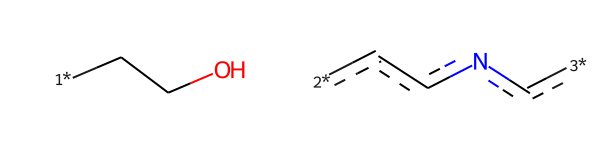

In [17]:
core = Chem.MolFromSmiles('c1cNcc1')
Chem.ReplaceCore(m, core)
frags = Chem.GetMolFrags(Chem.ReplaceCore(m, core), asMols=True, sanitizeFrags=False)

Draw.MolsToGridImage([x for x in frags], molsPerRow=2, subImgSize=(300,150))
